In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/PAKDD/CourtDetection

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/PAKDD/CourtDetection


## Function for Court Detection
### 1.merge lines
### 2.find line intersection
### 3.remove close point 
### 4.find the point near corner



In [27]:
def closest_points_to_corners(intersections, image):
    height, width,_ = image.shape

    corners = [(0, 0), (width, 0), (0, height), (width, height)]
    closest_points = []

    for corner in corners:
        min_distance = float('inf')
        closest_point = None

        for intersection in intersections:
            distance = np.sqrt((corner[0] - intersection[0]) ** 2 + (corner[1] - intersection[1]) ** 2)

            if distance < min_distance:
                min_distance = distance
                closest_point = intersection

        closest_points.append(closest_point)

    return closest_points

In [28]:
def remove_close_points(points, threshold):
    filtered_points = []

    for point in points:
        x1, y1 = point

        # check point distance
        for filtered_point in filtered_points:
            x2, y2 = filtered_point

            # < threshold two point are the same
            if np.sqrt((x1 - x2)**2 + (y1 - y2)**2) < threshold:
                break
        else:
            filtered_points.append(point)

    return filtered_points

In [29]:

def line_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    
    # linear function
    try:
        x0, y0 = np.linalg.solve(A, b)
        if(abs(x0) > 2000 or abs(y0) > 2000 ):
            pass
        else:
            return int(x0), int(y0)
    except:
        return None


In [30]:
def merge_lines(lines, angle_threshold, distance_threshold):
    merged_lines = []
    for line in lines:
        rho, theta = line[0]
        angle = np.rad2deg(theta)
        
        # check two lines
        for m_line in merged_lines:
            m_rho, m_theta = m_line[0]
            m_angle = np.rad2deg(m_theta)

            # if angle and distance < threshold ,two lines are the same
            if (abs(angle - m_angle) < angle_threshold) and (abs(rho - m_rho) < distance_threshold):
                m_line[1] += 1
                break
        else:
            merged_lines.append([line[0], 1])

    return [line[0] for line in merged_lines]

In [31]:
def separate_lines(lines, height):
    upper_lines = []
    lower_lines = []

    for line in lines:
        rho, theta = line[0]
        y = rho * np.sin(theta)

        if y < height / 2:
            upper_lines.append(line)
        else:
            lower_lines.append(line)

    return upper_lines, lower_lines

In [32]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table) # apply gamma correction using the lookup table

# Import Module

In [33]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# read image and do image preprocessing


In [34]:

image = cv2.imread("0.jpg")
line = image.copy()
frame = image.copy()
frame2 = image.copy()
frame3 = image.copy()
frame4 = image.copy()

green = np.uint8([[[0,255,0]]])
range1 = [20,255,200]
range2 = [20,0,0]
hsv_green = cv2.cvtColor(green, cv2.COLOR_BGR2HSV)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)        
mask = cv2.inRange(hsv, hsv_green-range1, hsv_green+range2)
res = cv2.bitwise_and(image, image, mask=mask)
res = adjust_gamma(res, 1.0)
image_gray = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
image = image_gray



#
ret, output1 = cv2.threshold(image, 235, 255, cv2.THRESH_BINARY) 
binary = cv2.adaptiveThreshold(output1,255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 5) 
kernel = np.ones((2,2), np.uint8)
erosion = cv2.erode(binary, kernel, iterations = 2)
dilation = cv2.dilate(erosion, kernel, iterations = 2)
erosion = cv2.erode(dilation, kernel, iterations = 2)


edges = cv2.Canny(erosion,50,150)

# find lines using HoughLines algorithm and find the point using line intersection


In [35]:
lines = cv2.HoughLines(edges,1,np.pi/180,200)

height = image.shape[0]
#seperate lines
upper_lines, lower_lines = separate_lines(lines, height)

# 上半部分的threshold
upper_angle_threshold = 25
upper_distance_threshold = 30

# 下半部分的threshold
lower_angle_threshold = 55
lower_distance_threshold = 55

# merge_line
merged_upper_lines = merge_lines(upper_lines, upper_angle_threshold, upper_distance_threshold)
merged_lower_lines = merge_lines(lower_lines, lower_angle_threshold, lower_distance_threshold)

# combine upper and lower lines
merged_lines = merged_upper_lines + merged_lower_lines

for line in merged_lines:
    rho, theta = line
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    cv2.line(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
    



intersections = []
for i, line1 in enumerate(merged_lines):
    for line2 in merged_lines[i+1:]:
        intersection = line_intersection(line1, line2)
        if intersection is not None:
            intersections.append(intersection)


for intersection in intersections:
    cv2.circle(frame, intersection, 8, (0, 0, 255), -1)    


distance_threshold = 5  # threshold
filtered_intersections = remove_close_points(intersections, distance_threshold)


for intersection in filtered_intersections:
    cv2.circle(frame2, intersection, 8, (0, 0, 255), -1)



# find the court corner 

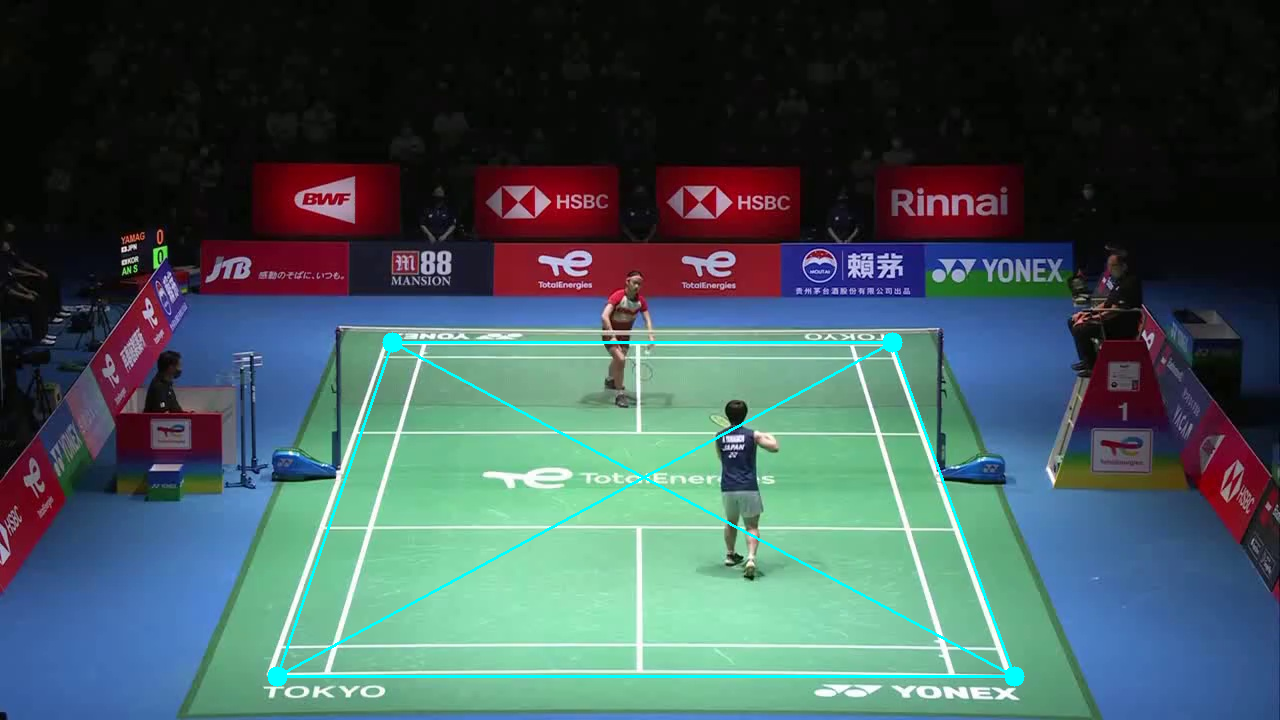

In [36]:
closest_points = closest_points_to_corners(filtered_intersections, frame)


for point in closest_points:
    cv2.circle(frame3, point, 10, (255, 255, 0), -1)
for i in range(len(closest_points)):
    for j in range(i+1, len(closest_points)):
        cv2.line(frame3, tuple(closest_points[i]), tuple(closest_points[j]), (255, 255, 0), 2)
cv2_imshow(frame3)


cv2.waitKey(0)
cv2.destroyAllWindows()